In [2]:
# ==================== FILE & DATA HANDLING ====================
import os
import glob
import random
import numpy as np
import pandas as pd
from PIL import Image

# ==================== DATA VISUALIZATION ====================
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from IPython.display import display

# ==================== MODEL EVALUATION ====================
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# ==================== DEEP LEARNING ====================
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D, 
                                   Dropout, BatchNormalization)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import (EarlyStopping, 
                                      ModelCheckpoint)
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

In [3]:
train_df = pd.read_csv("Data/Training_set.csv")  # Training data DataFrame
test_df = pd.read_csv("Data/Testing_set.csv")    # Testing data DataFrame

In [4]:
train_image_files = glob.glob("Data/train/*.jpg")  # Training image files  
test_image_files = glob.glob("Data/test/*.jpg")    # Test image files  

In [6]:
image_filenames = train_df['filename']  # List of image filenames
activity_labels = train_df['label']     # List of activity labels

In [7]:
# Initialize containers for image data and labels
image_data = []
image_labels = []

# Predefined image size
TARGET_IMAGE_SIZE = (224, 224)
TRAIN_DATA_PATH = 'Data/train/'

# Process each image in the training folder
for i in range(len(train_image_files)):
    try:
        # Construct full image path
        image_path = os.path.join(TRAIN_DATA_PATH, image_filenames[i])
        
        # Open and resize image
        with Image.open(image_path) as img:
            resized_img = img.resize(TARGET_IMAGE_SIZE)
            image_data.append(np.asarray(resized_img))
            image_labels.append(activity_labels[i])
            
    except Exception as e:
        print(f"Error processing image {image_filenames[i]}: {str(e)}")
        continue

# Convert to numpy arrays for machine learning
image_data = np.array(image_data)
image_labels = np.array(image_labels)

In [8]:
# Convert image data list to numpy array
X = np.array(image_data)  # More descriptive variable name

# Verify the conversion
print(f"Data type: {type(X)}")
print(f"Number of images: {len(X)}")
print(f"Array shape: {X.shape}")  # Added shape information
print(f"Data type: {X.dtype}")   # Added dtype information

Data type: <class 'numpy.ndarray'>
Number of images: 12600
Array shape: (12600, 224, 224, 3)
Data type: uint8


In [9]:
# Convert labels to categorical one-hot encoding
activity_labels = train_df["label"]
label_codes, unique_labels = pd.factorize(activity_labels)
y = to_categorical(label_codes)

# Print information about the conversion
print("Label Encoding Details:")
print(f"Unique activity classes: {unique_labels}")
print(f"Number of classes: {len(unique_labels)}")
print(f"First encoded sample: {y[0]}")
print(f"Shape of y_train: {y.shape}")

# Create a mapping dictionary for reference
label_mapping = {i: label for i, label in enumerate(unique_labels)}
print("\nClass Index to Label Mapping:")
for index, label in label_mapping.items():
    print(f"Class {index}: {label}")

Label Encoding Details:
Unique activity classes: Index(['sitting', 'using_laptop', 'hugging', 'sleeping', 'drinking',
       'clapping', 'dancing', 'cycling', 'calling', 'laughing', 'eating',
       'fighting', 'listening_to_music', 'running', 'texting'],
      dtype='object')
Number of classes: 15
First encoded sample: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Shape of y_train: (12600, 15)

Class Index to Label Mapping:
Class 0: sitting
Class 1: using_laptop
Class 2: hugging
Class 3: sleeping
Class 4: drinking
Class 5: clapping
Class 6: dancing
Class 7: cycling
Class 8: calling
Class 9: laughing
Class 10: eating
Class 11: fighting
Class 12: listening_to_music
Class 13: running
Class 14: texting


In [10]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
    random_state=42,  # for reproducibility
    stratify=y       # preserve class distribution
)

# Normalize pixel values to be between 0 and 1
#X_train = X_train.astype('float32') / 255.0
#X_test = X_test.astype('float32') / 255.0

# Print dataset information
print("Dataset Information:")
print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test set shape: X_test={X_test.shape}, y_test={y_test.shape}")
print(f"Pixel value range - Min: {X_train.min()}, Max: {X_train.max()}")

Dataset Information:
Training set shape: X_train=(10080, 224, 224, 3), y_train=(10080, 15)
Test set shape: X_test=(2520, 224, 224, 3), y_test=(2520, 15)
Pixel value range - Min: 0, Max: 255


In [11]:
def read_img(fn,size=(224,224)):
    img = Image.open(fn)
    return np.asarray(img.resize(size))

In [12]:
def test_predict(test_image,model):
    # List of class labels matching the order of class indices
    class_labels = [
        'sitting',
        'using_laptop',
        'hugging',
        'sleeping',
        'drinking',
        'clapping',
        'dancing',
        'cycling',
        'calling',
        'laughing',
        'eating',
        'fighting',
        'listening_to_music',
        'running',
        'texting'
    ]
    
    # Model prediction
    result = model.predict(np.asarray([read_img(test_image)]))
    probabilities = result[0]  # Get the probability vector
    
    # Create a pandas DataFrame for the probabilities
    prob_df = pd.DataFrame({
        'Class Index': range(len(class_labels)),
        'Label': class_labels,
        'Probability (%)': (probabilities * 100).round(2)
    }).sort_values('Probability (%)', ascending=False)
    
    # Add a rank column
    prob_df['Rank'] = range(1, len(prob_df)+1)
    
    # Get predicted class
    predicted_class = np.argmax(probabilities)
    probability = np.max(probabilities) * 100
    predicted_label = class_labels[predicted_class]
    
    # Print the probability table
    #print("\nProbability Distribution:")
    #print(prob_df.to_string(index=False))
    
    # Print top prediction
    print(f"\nTop Prediction: {predicted_label} (class {predicted_class}) with {probability:.2f}% confidence")
    
    # Display image with prediction
    image = img.imread(test_image)
    plt.imshow(image)
    plt.title(f"Prediction: {predicted_label}\nConfidence: {probability:.2f}%", fontsize=10)
    plt.axis('off')
    
    # Display the table below the image
    plt.show()
    display(prob_df.style
            .background_gradient(cmap='Blues', subset=['Probability (%)'])
            .set_caption('Class Probabilities'))

In [22]:
import numpy as np

def diagonal_to_total_percentage(matrix):
    total_sum = np.sum(matrix)  # Sum of all matrix elements
    diagonal_sum = np.trace(matrix)  # Sum of main diagonal elements
    if total_sum == 0:
        return 0.0  # Prevent division by zero
    percentage = (diagonal_sum / total_sum) * 100  # Calculate percentage
    return percentage


#percentage = diagonal_to_total_percentage(cm)
#print("Percentage of main diagonal sum relative to total matrix: {:.2f}%".format(percentage))

In [13]:
model_3 = load_model('Models/model_3.keras')
input_shape = model_3.input_shape  
print("Input Shape:", input_shape)  
model_3.summary()

Input Shape: (None, 224, 224, 3)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,691,090 (17.90 MB)

 Trainable params: 226,991 (886.68 KB)

 Non-trainable params: 4,010,115 (15.30 MB)

 Optimizer params: 453,984 (1.73 MB)

In [17]:
model_4 = load_model('Models/model_4.keras')
input_shape = model_4.input_shape  
print("Input Shape:", input_shape)  
model_4.summary()

Input Shape: (None, 224, 224, 3)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 7, 7, 1536)          │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         196,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 15)                  │             495 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,843,458 (113.84 MB)

 Trainable params: 9,426,209 (35.96 MB)

 Non-trainable params: 1,564,829 (5.97 MB)

 Optimizer params: 18,852,420 (71.92 MB)

In [18]:
model_5 = load_model('Models/model_5.keras')
input_shape = model_5.input_shape  
print("Input Shape:", input_shape)  
model_5.summary()

Input Shape: (None, 224, 224, 3)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ efficientnetv2-s (Functional) │ (None, 7, 7, 1280)        │      20,331,360 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling2d      │ (None, 1280)              │               0 │ efficientnetv2-s[0][0]     │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling2d          │ (None, 1280)              │               0 │ efficientnetv2-s[0][0]     │
│ (GlobalMaxPooling2D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 160)               │         204,960 │ global_average_pooling2d[… │
│                               │                           │                 │ global_max_pooling2d[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1280)              │         206,080 │ dense[0][0], dense[1][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 1280)              │               0 │ dense_1[0][0],             │
│                               │                           │                 │ dense_1[1][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 1, 1, 1280)        │               0 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multiply (Multiply)           │ (None, 7, 7, 1280)        │               0 │ efficientnetv2-s[0][0],    │
│                               │                           │                 │ reshape[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling2d_1    │ (None, 1280)              │               0 │ multiply[0][0]             │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 1280)              │           5,120 │ global_average_pooling2d_… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 256)               │         327,936 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 256)               │               0 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 128)               │          32,89

 Total params: 63,019,022 (240.40 MB)

 Trainable params: 20,954,111 (79.93 MB)

 Non-trainable params: 156,688 (612.06 KB)

 Optimizer params: 41,908,223 (159.87 MB)

In [19]:
X_test.shape

(2520, 224, 224, 3)

In [20]:
class_names = ['sitting', 'using_laptop', 'hugging', 'sleeping', 'drinking',
       'clapping', 'dancing', 'cycling', 'calling', 'laughing', 'eating',
       'fighting', 'listening_to_music', 'running', 'texting']

In [38]:
import numpy as np

# Model prediction (output is class probabilities)
y_pred_probs = model_3.predict(X_test)

# Convert probabilities to class labels (0 to 14 for 15 classes)
y_pred = np.argmax(y_pred_probs, axis=1)

# If y_test is one-hot encoded, convert it to labels as well
y_true = np.argmax(y_test, axis=1)

79/79 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step


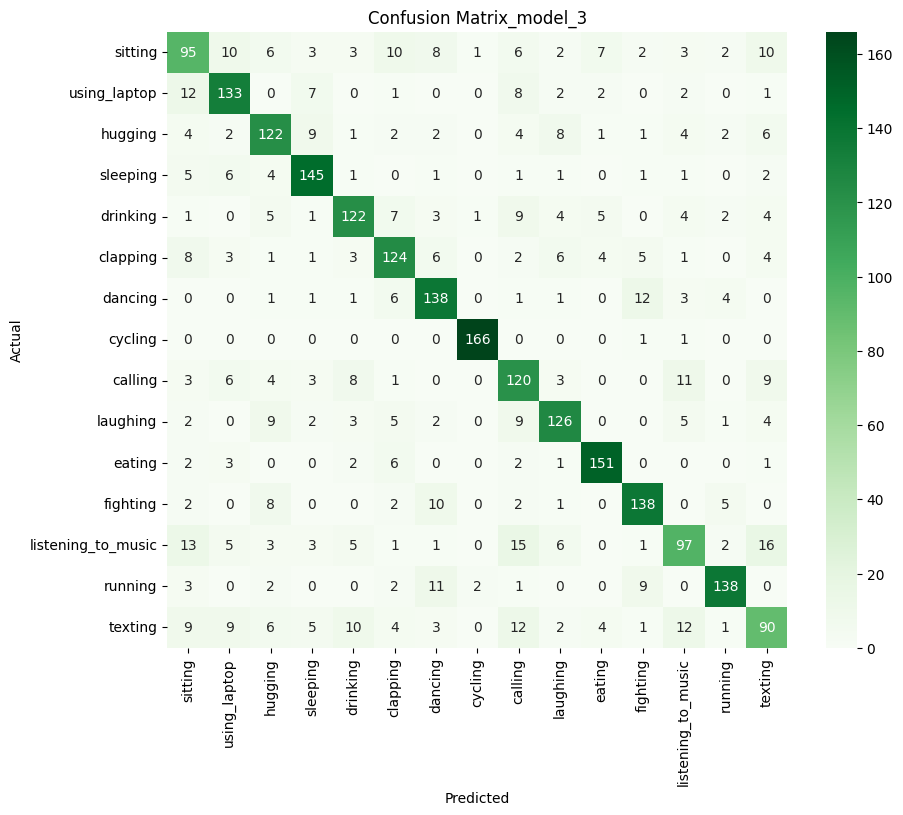

In [39]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')  # Alternatively: 'True' (both are correct)
plt.title('Confusion Matrix_model_3')
plt.show()

In [40]:
percentage = diagonal_to_total_percentage(cm)
print("Percentage of main diagonal sum relative to total matrix: {:.2f}%".format(percentage))

Percentage of main diagonal sum relative to total matrix: 75.60%


In [ ]:
########################
########################
########################

In [25]:
# Model prediction (output is class probabilities)
y_pred_probs = model_4.predict(X_test)

# Convert probabilities to class labels (0 to 14 for 15 classes)
y_pred = np.argmax(y_pred_probs, axis=1)

# If y_test is one-hot encoded, convert it to labels as well
y_true = np.argmax(y_test, axis=1)

79/79 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step


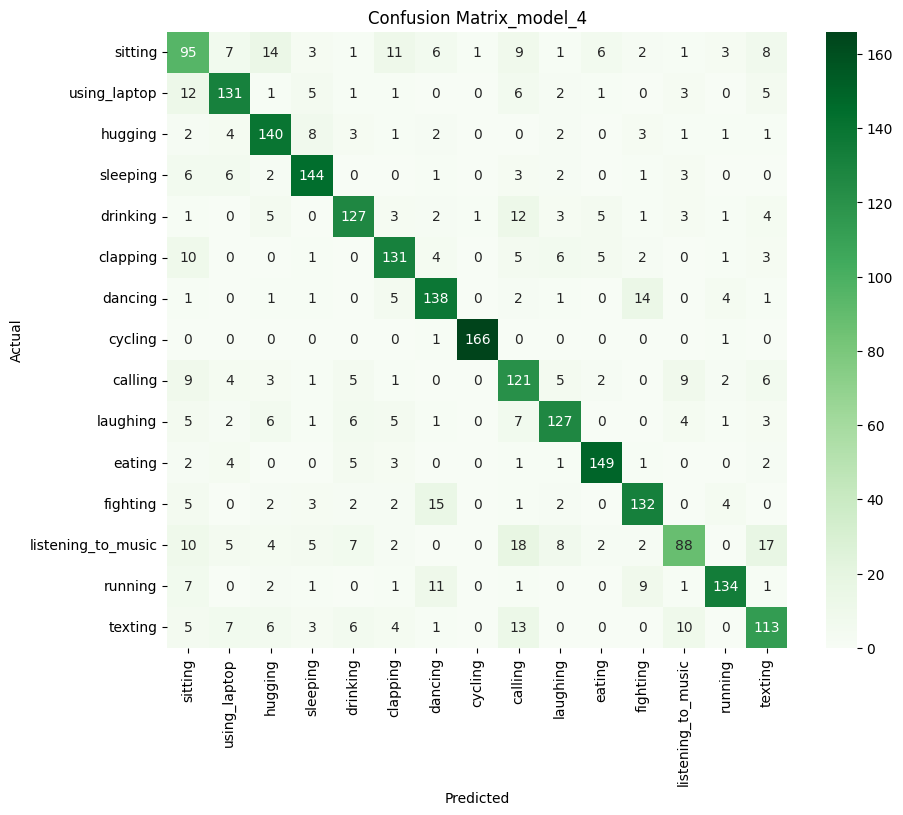

In [31]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')  # Alternatively: 'True' (both are correct)
plt.title('Confusion Matrix_model_4')
plt.show()

In [33]:
percentage = diagonal_to_total_percentage(cm)
print("Percentage of main diagonal sum relative to total matrix: {:.2f}%".format(percentage))

Percentage of main diagonal sum relative to total matrix: 76.83%


In [ ]:
########################
########################
########################

In [34]:
# Model prediction (output is class probabilities)
y_pred_probs = model_5.predict(X_test)

# Convert probabilities to class labels (0 to 14 for 15 classes)
y_pred = np.argmax(y_pred_probs, axis=1)

# If y_test is one-hot encoded, convert it to labels as well
y_true = np.argmax(y_test, axis=1)

79/79 ━━━━━━━━━━━━━━━━━━━━ 68s 856ms/step


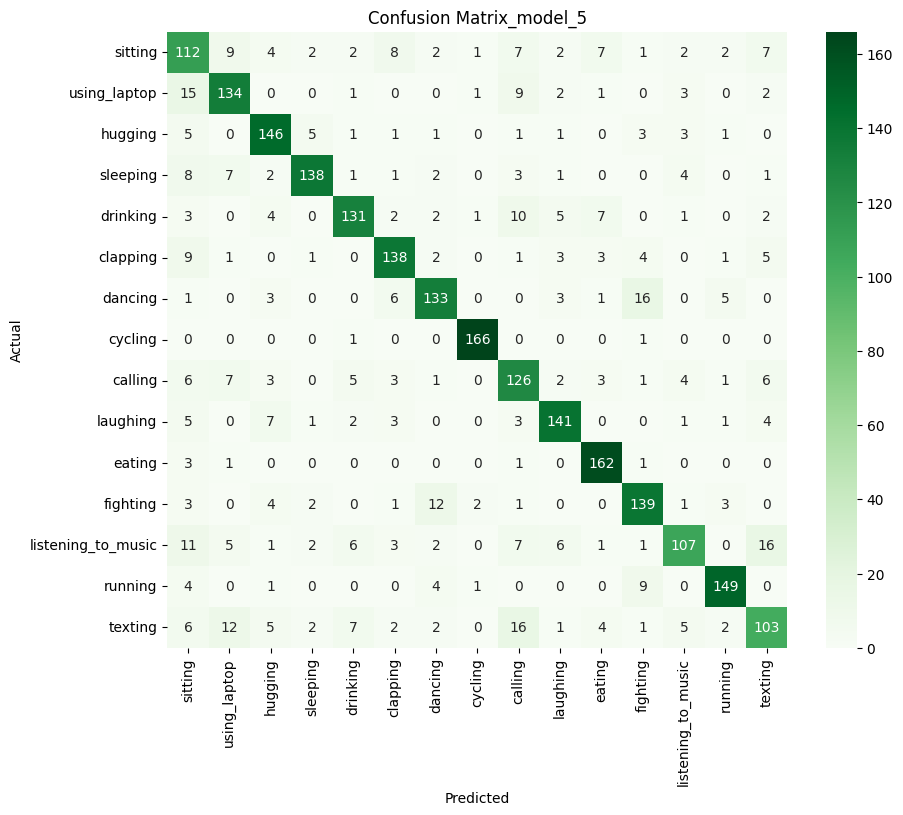

In [36]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')  # Alternatively: 'True' (both are correct)
plt.title('Confusion Matrix_model_5')
plt.show()

In [37]:
percentage = diagonal_to_total_percentage(cm)
print("Percentage of main diagonal sum relative to total matrix: {:.2f}%".format(percentage))

Percentage of main diagonal sum relative to total matrix: 80.36%


In [ ]:
########################
########################
########################